In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
# DATA PATH
RAW_DATA_PATH = os.path.join("..","datasets","raw","airline_passengers.csv")
RAW_DATA_PATH

'../datasets/raw/airline_passengers.csv'

In [3]:
air = pd.read_csv(RAW_DATA_PATH, parse_dates=['Month'], index_col='Month', squeeze=True)
air

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: AirPassengers, Length: 144, dtype: int64

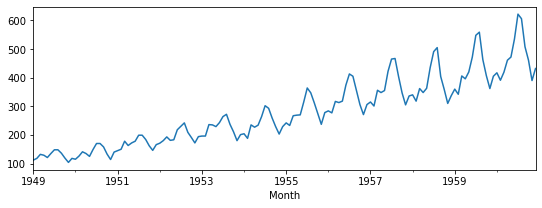

In [4]:
air.plot(figsize=(9,3))
plt.show()

## Time Series Decomposition

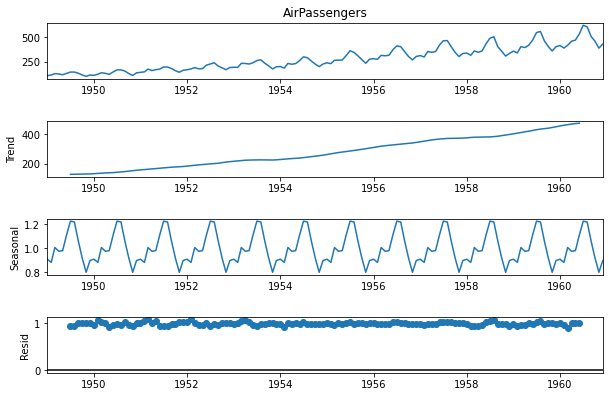

In [5]:
result = seasonal_decompose(air, model='multiplicative')
fig = result.plot()
fig.set_size_inches((9,6))
#plt.savefig('../img/seasonal_decompose.jpg')
plt.show()

## Augmented Dickey-Fuller Test

In [6]:
%run ../auxiliar_functions/ADFullerResults.py

ADFullerResults(air)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## Transformation

### Differencing 

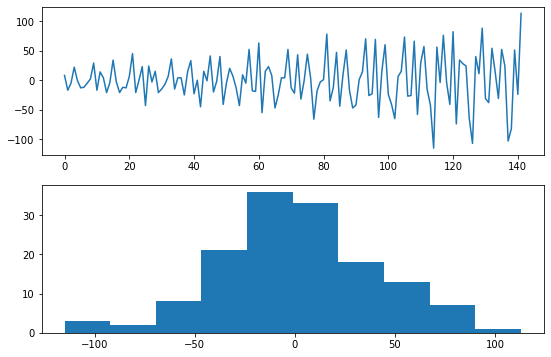

In [7]:
# Differencing - 2
air_diff = np.diff(air, n=2)

plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(air_diff)
plt.subplot(212)
plt.hist(air_diff)
plt.show()

In [8]:
ADFullerResults(air_diff)

ADF Statistic: -16.384232
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


### Box-Cox

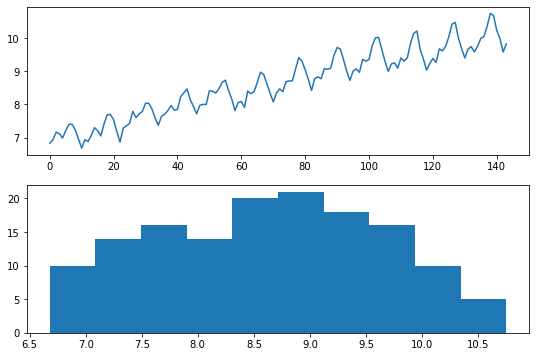

Lambda: 0.14802265137037945


In [9]:
# BoxCox Transformation
box, lam = boxcox(air)

plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(box)
plt.subplot(212)
plt.hist(box)
plt.show()
print("Lambda: "+str(lam))

In [10]:
ADFullerResults(box)

ADF Statistic: -1.326071
p-value: 0.617162
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## Autocorrelation and Partial Autocorrelation

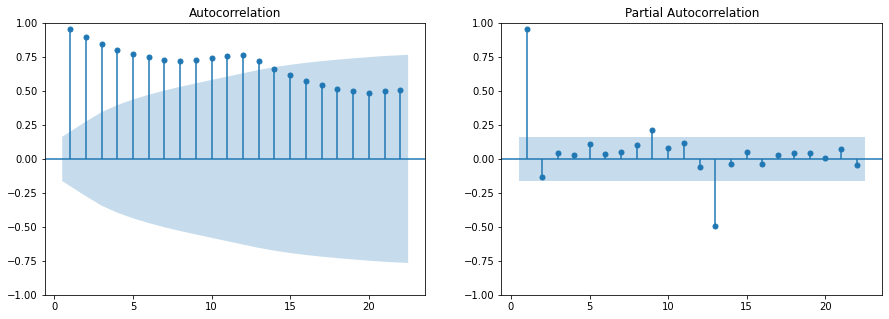

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_acf(box, zero=False, ax=ax[0])
plot_pacf(box, method='ywm', zero=False, ax=ax[1])
plt.show()

## Searching for best order

In [15]:
akaike = list()
for p in range(1,8):
    for q in range(1,8):
        try:
            model = ARIMA(air_diff, order=(p,2,q))
            res = model.fit()
            akaike.append([p,q, round(res.aic, 1)])
        except:
            akaike.append([p,q, None])

aic = pd.DataFrame(akaike, columns=["p","q","aic"])
aic.sort_values(by="aic", ignore_index=True, )[:3]

,p,q,aic
0,2,6,1400.8
1,5,5,1402.0
2,3,7,1406.7


In [16]:
model = ARIMA(air_diff, order=(2,2,6))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  142
Model:                 ARIMA(2, 2, 6)   Log Likelihood                -691.393
Date:                Fri, 19 Aug 2022   AIC                           1400.787
Time:                        20:02:50   BIC                           1427.262
Sample:                             0   HQIC                          1411.545
                                - 142                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9764      0.028    -35.387      0.000      -1.030      -0.922
ar.L2         -0.9952      0.013    -75.475      0.000      -1.021      -0.969
ma.L1         -1.5830   7891.405     -0.000      1.000   -1.55e+04    1.55e+04
ma.L2          0.2172   3794.028   5.72e-05      1.000   -7435.942    7436.376
ma.L3         -0.6293    1.2e+04  -5.25e-05      1.000   -2.35e+04    2.35e+04
ma.L4          1.4229   3794.260      0.000      1.000   -7435.190    7438.036
ma.L5          0.0912   4095.861   2.23e-05      1.000   -8027.648    8027.831
ma.L6         -0.5190      0.110     -4.740      0.000      -0.734      -0.304
sigma2       868.1068     14.478     59.962      0.000     839.731     896.482
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                93.18
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               7.67   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+22. Standard errors may be unstable.
"""

### Splitting Data

In [ ]:
air[:-6].to_csv('../datasets/processed/train.csv')
air[-6:].to_csv('../datasets/processed/test.csv')